# Restaurant Review Sentiment Analysis

The aim of this project is to create a sentiment analysis model for reviews of a restaurant.

Data Source : https://www.kaggle.com/datasets/d4rklucif3r/restaurant-reviews/data

# Import Libraries

In [1]:
pip install tensorflow

In [2]:
import re
import nltk
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as tf_hub

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS

nltk.download('stopwords')
nltk.download('punkt')
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, Input, LSTM, GRU, Dropout, Reshape
from tensorflow.keras.layers import Embedding, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import TextVectorization

from sklearn.metrics import classification_report
import tensorflow_hub as hub

#  Ignore warnings
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#  Data Loading

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df=pd.read_csv('/content/drive/MyDrive/Hactiv8/Restaurant_Reviews.tsv',sep='\t')
df

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


This Dataset contains two rows Customer Reviews and Liked.
Customer reviews tells us about the reviews given by the customers for a food in restaurant and liked column tells about whether they liked the food or not.

In [5]:
df.shape

(1000, 2)

In [6]:
df['Liked'].value_counts()

1    500
0    500
Name: Liked, dtype: int64

In [7]:
df.isnull().sum()

Review    0
Liked     0
dtype: int64

# Exploratory Data Analysis (EDA)

In [8]:
df['Review']

0                               Wow... Loved this place.
1                                     Crust is not good.
2              Not tasty and the texture was just nasty.
3      Stopped by during the late May bank holiday of...
4      The selection on the menu was great and so wer...
                             ...                        
995    I think food should have flavor and texture an...
996                             Appetite instantly gone.
997    Overall I was not impressed and would not go b...
998    The whole experience was underwhelming, and I ...
999    Then, as if I hadn't wasted enough of my life ...
Name: Review, Length: 1000, dtype: object

Text(0.5, 1.0, 'Liked or Not Percentage')

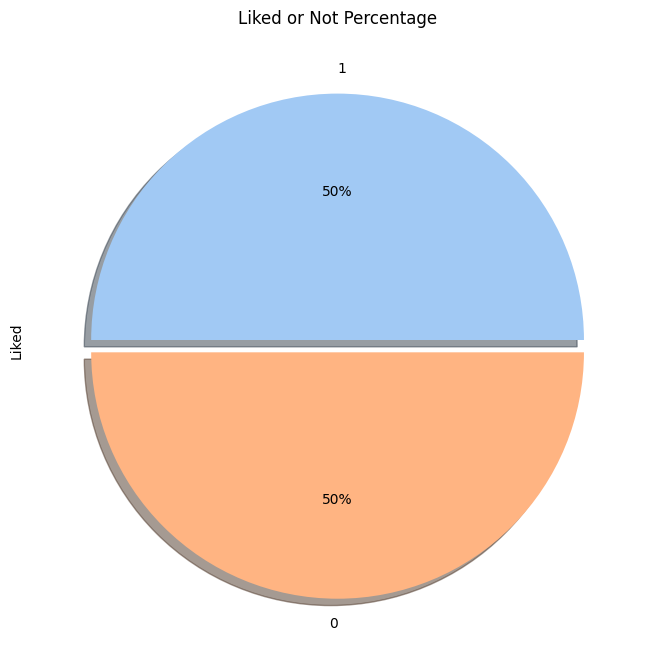

In [9]:
# plotting data on chart
df['Liked'].value_counts().plot(kind='pie', figsize=(8,8),  autopct='%.0f%%', explode = [0, 0.05], shadow=True, colors=sns.color_palette('pastel'))
plt.title('Liked or Not Percentage')

Insight : In the pie chart above, 0 means customer like the restaurant and 1 stands for not.

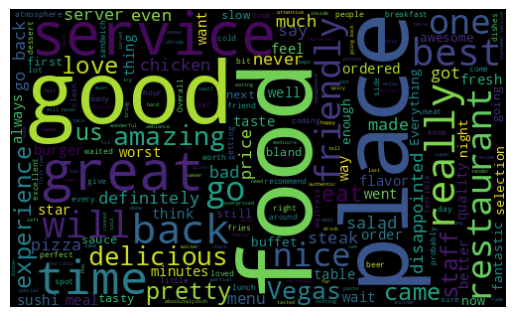

In [10]:
# Combine all messages into a single string
all_messages = ' '.join(df['Review'])
wordCloud = WordCloud(width=500, height=300, random_state=20, max_font_size=100).generate(all_messages)
# Display the WordCloud image
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Feature Engineering

In [11]:
# checking
teks = df.Review[0]
teks

'Wow... Loved this place.'

Eliminate the stopwords

In [12]:
# Stopwords
stpwds_eng = list(set(stopwords.words('english')))
stpwds_eng.append(['oh','s'])

Lemmatization, a method is employed to decrease and transform words into their base forms. For instance, converting "running" to "run" or "feet" to "foot," etc. Lemmatization is considered superior to stemming since stemming merely involves truncating or slicing letters without placing significant emphasis on the word's context.


In [13]:
# lemmatization
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
#Create Preprocessing Function
def text_preprocessing(text):

  text = text.lower() #to lowercase

  text = re.sub("@[A-Za-z0-9_]+", " ", text)# Remove Mention

  text = re.sub("#[A-Za-z0-9_]+", " ", text)# Remove Hashtag

  text = re.sub(r"\\n", " ",text)# Remove \n

  text = text.strip() # Remove Whitespace

  text = re.sub(r"http\S+", " ", text) # Remove Link
  text = re.sub(r"www.\S+", " ", text)

  text = re.sub("[^A-Za-z\s']", " ", text)# Remove symbols, emojis

  tokens = word_tokenize(text)# Tokenization

  text = ' '.join([word for word in tokens if word not in stopwords.words('english')])# Remove Stopwords

  text = lemmatizer.lemmatize(text)# Lemmatizing using WordLemmatizer

  return text

In [15]:
# check after and before pre processing
print("after :" ,text_preprocessing(teks))
print("before :" ,teks)

after : wow loved place
before : Wow... Loved this place.


In [16]:
# making sure all the data in message is str
df['Review'] =  df['Review'].astype(str)

In [17]:
# Applying the function of pre processing
df['text_processed'] = df['Review'].apply(lambda x: text_preprocessing(x))
df.head(5)

,Review,Liked,text_processed
0,Wow... Loved this place.,1,wow loved place
1,Crust is not good.,0,crust good
2,Not tasty and the texture was just nasty.,0,tasty texture nasty
3,Stopped by during the late May bank holiday of...,1,stopped late may bank holiday rick steve recom...
4,The selection on the menu was great and so wer...,1,selection menu great prices


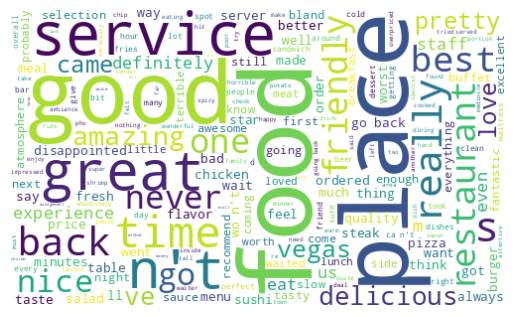

In [18]:
# Combine all messages into a single string
all_messages = ' '.join(df['text_processed'])

# Create a WordCloud object with the desired settings
wordCloud = WordCloud(width=500, height=300, random_state=20, max_font_size=100, background_color="white").generate(all_messages)

# Display the WordCloud image
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Insight : this is the wordcloud after preprocessing.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Review          1000 non-null   object
 1   Liked           1000 non-null   int64 
 2   text_processed  1000 non-null   object
dtypes: int64(1), object(2)
memory usage: 23.6+ KB


In [20]:
# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(df.text_processed,
                                                    df.Liked,
                                                    test_size=0.20,
                                                    random_state=10,
                                                    stratify=df.Liked)

print('Train Size : ', X_train.shape)
print('Test Size  : ', X_test.shape)

Train Size :  (800,)
Test Size  :  (200,)


Do vectorization, is a method that transforms words into numerical vectors for processing in the model. We will utilize the CountVectorizer to dissect and convert sentences and texts into vectors.

In [21]:
Vectorize = CountVectorizer()
X_train_vec = Vectorize.fit_transform(X_train)
X_test_vec = Vectorize.transform(X_test)
X_train_vec

<800x1661 sparse matrix of type '<class 'numpy.int64'>'
	with 4384 stored elements in Compressed Sparse Row format>

In [22]:
# Finding the Number of Vocabs and Max Token Length in One Document
total_vocab = len(Vectorize.vocabulary_.keys())
max_sen_len = max([len(i.split(" ")) for i in X_train])

print('Total Vocab : ', total_vocab)
print('Maximum Sentence Length : ', max_sen_len, 'tokens')

Total Vocab :  1661
Maximum Sentence Length :  19 tokens


The purpose of the TextVectorization layer is to convert raw text data into a numerical format that can be used as input to a neural network model

In [23]:
# Text Vectorization
text_vectorization = TextVectorization(max_tokens=total_vocab,
                                       standardize="lower_and_strip_punctuation",
                                       split="whitespace",
                                       ngrams=None,
                                       output_mode="int",
                                       output_sequence_length=max_sen_len,
                                       input_shape=(1,))

text_vectorization.adapt(X_train)

In [24]:
# Embedding
embedding = Embedding(input_dim=total_vocab,
                      output_dim=64,
                      embeddings_initializer="uniform",
                      input_length=max_sen_len
                      )

# ANN Training (Sequential API & Functional API)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 19)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 19, 64)            106304    
                                                                 
 flatten (Flatten)           (None, 1216)              0         
                                                                 
 dense (Dense)               (None, 16)                19472     
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 125793 (491.38 KB)
Trainable params: 125793 (491.38 KB)
Non-trainable params: 0 (0.00 Byte)
________________

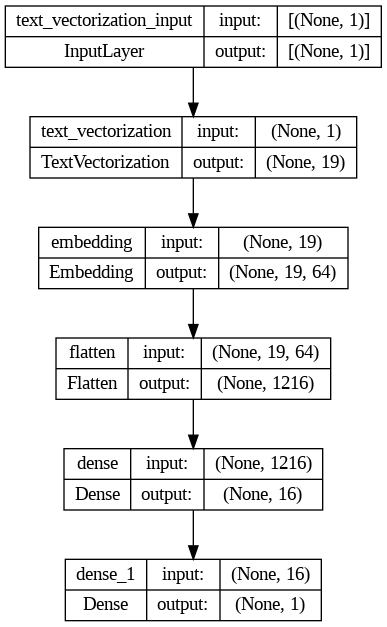

In [25]:
# Sequential Model Definition
model_s = Sequential()
model_s.add(text_vectorization)
model_s.add(embedding)
model_s.add(Flatten())
model_s.add(Dense(16,activation='relu'))
model_s.add(Dense(1,activation='sigmoid'))

model_s.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')
model_s.summary()
tf.keras.utils.plot_model(model_s,show_shapes=True)

**Applying**

- Two hidden layer namely embedding layer and dense layer with 16 neurons.

- Activation relu on dense layer for better performance, and activation sigmoid in output layer becase of binary case.

In [26]:
#model training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_seq_1 =model_s.fit(X_train,
                         y_train,
                         epochs=50,
                         batch_size=64,
                         validation_data=(X_test, y_test),
                         callbacks=[early_stopping])

Epoch 1/50
13/13 [==============================] - 5s 112ms/step - loss: 0.6947 - accuracy: 0.4975 - val_loss: 0.6921 - val_accuracy: 0.5000
Epoch 2/50
13/13 [==============================] - 0s 26ms/step - loss: 0.6773 - accuracy: 0.7600 - val_loss: 0.6868 - val_accuracy: 0.5150
Epoch 3/50
13/13 [==============================] - 0s 25ms/step - loss: 0.6435 - accuracy: 0.8300 - val_loss: 0.6731 - val_accuracy: 0.5900
Epoch 4/50
13/13 [==============================] - 0s 27ms/step - loss: 0.5789 - accuracy: 0.8425 - val_loss: 0.6449 - val_accuracy: 0.6600
Epoch 5/50
13/13 [==============================] - 0s 27ms/step - loss: 0.4708 - accuracy: 0.9563 - val_loss: 0.6024 - val_accuracy: 0.6900
Epoch 6/50
13/13 [==============================] - 0s 29ms/step - loss: 0.3411 - accuracy: 0.9700 - val_loss: 0.5597 - val_accuracy: 0.7000
Epoch 7/50
13/13 [==============================] - 0s 23ms/step - loss: 0.2328 - accuracy: 0.9762 - val_loss: 0.5285 - val_accuracy: 0.7250
Epoch 8/50
1

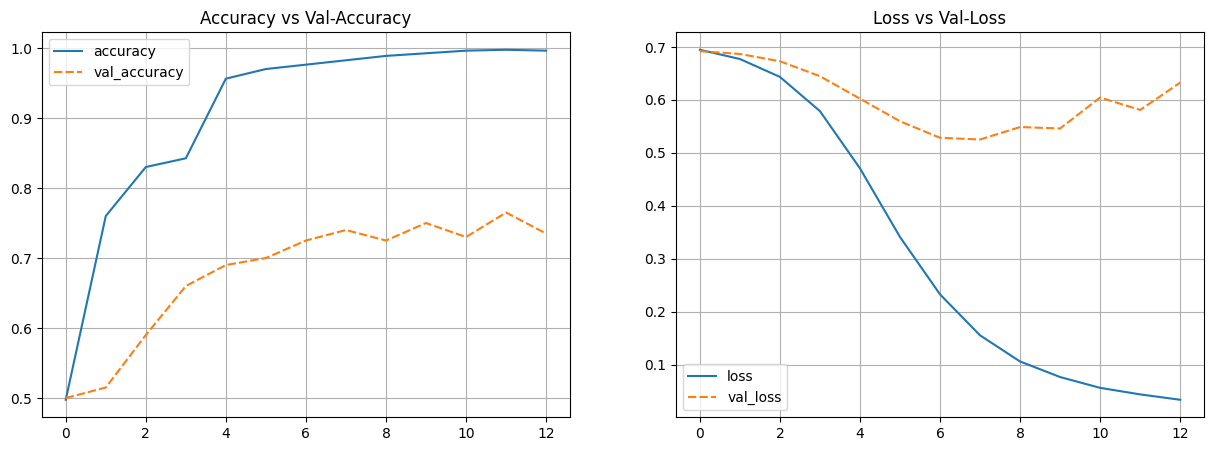

In [27]:
# Plot Training Results of sequential models
model_1_seq = pd.DataFrame(model_seq_1.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=model_1_seq[['accuracy', 'val_accuracy']])
plt.grid()
plt.title('Accuracy vs Val-Accuracy')

plt.subplot(1, 2, 2)
sns.lineplot(data=model_1_seq[['loss', 'val_loss']])
plt.grid()
plt.title('Loss vs Val-Loss')
plt.show()

**Evaluation** :
We can see from the base model, there is definietly indication for overfittng because the big gap between accuracy and val_accuracy. Also val_loss line keeps getting worse in each epoch and distance itself from loss in train data.

# ANN Improvement (Sequential API & Functional API)

**GRU Model**

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 19)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 19, 64)            106304    
                                                                 
 bidirectional (Bidirection  (None, 19, 128)           49920     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 19, 128)           0         
                                                                 
 batch_normalization (Batch  (None, 19, 128)           512   

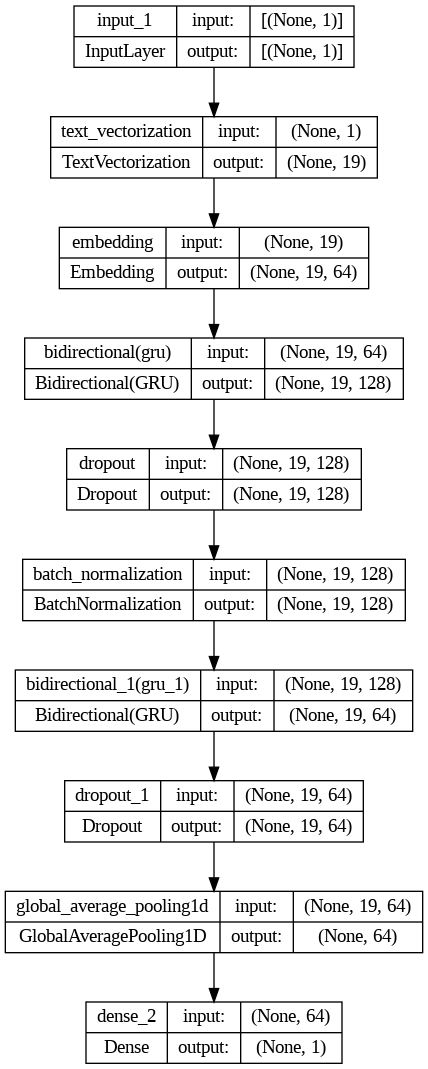

In [28]:
input_layer = Input(shape=(1,), dtype=tf.string)

x = text_vectorization(input_layer)
x = embedding(x)

# GRU Layers
x = Bidirectional(GRU(64, activation='relu', return_sequences=True))(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Bidirectional(GRU(32, activation='relu', return_sequences=True))(x)
x = Dropout(0.5)(x)

x = GlobalAveragePooling1D()(x)
output_layer = Dense(1, activation='sigmoid')(x)

# Create the model using the functional API
model_func_gru = Model(inputs=input_layer, outputs=output_layer)

# Compilation
optimizer = Adam(learning_rate=0.001)
model_func_gru.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


model_func_gru.summary()
tf.keras.utils.plot_model(model_func_gru, show_shapes=True)

Applying :
- Bidirectional GRU layers are used for sequence processing.
- The first GRU layer has 64 units, uses the ReLU activation function, and returns sequences.
- Dropout and BatchNormalization are applied for regularization and normalization.
- The second GRU layer has 32 units with similar settings.

In [29]:
#model training
model_func_1 =model_func_gru.fit(X_train,
                         y_train,
                         epochs=15,
                         batch_size=64,
                         validation_data=(X_test, y_test))

Epoch 1/15
13/13 [==============================] - 10s 118ms/step - loss: 0.5455 - accuracy: 0.8525 - val_loss: 0.6843 - val_accuracy: 0.6950
Epoch 2/15
13/13 [==============================] - 1s 56ms/step - loss: 0.2563 - accuracy: 0.9475 - val_loss: 0.6599 - val_accuracy: 0.7300
Epoch 3/15
13/13 [==============================] - 1s 54ms/step - loss: 0.1093 - accuracy: 0.9650 - val_loss: 0.6282 - val_accuracy: 0.7300
Epoch 4/15
13/13 [==============================] - 1s 54ms/step - loss: 0.0669 - accuracy: 0.9800 - val_loss: 0.6166 - val_accuracy: 0.7400
Epoch 5/15
13/13 [==============================] - 1s 54ms/step - loss: 0.0464 - accuracy: 0.9875 - val_loss: 0.6096 - val_accuracy: 0.7300
Epoch 6/15
13/13 [==============================] - 1s 55ms/step - loss: 0.0379 - accuracy: 0.9862 - val_loss: 0.6026 - val_accuracy: 0.7300
Epoch 7/15
13/13 [==============================] - 1s 55ms/step - loss: 0.0228 - accuracy: 0.9912 - val_loss: 0.5905 - val_accuracy: 0.7500
Epoch 8/15


Insight : The model seems to be learning well from the training data, but not with test data. The model is clearly overfitting.

**LSTM Bidirectional models**

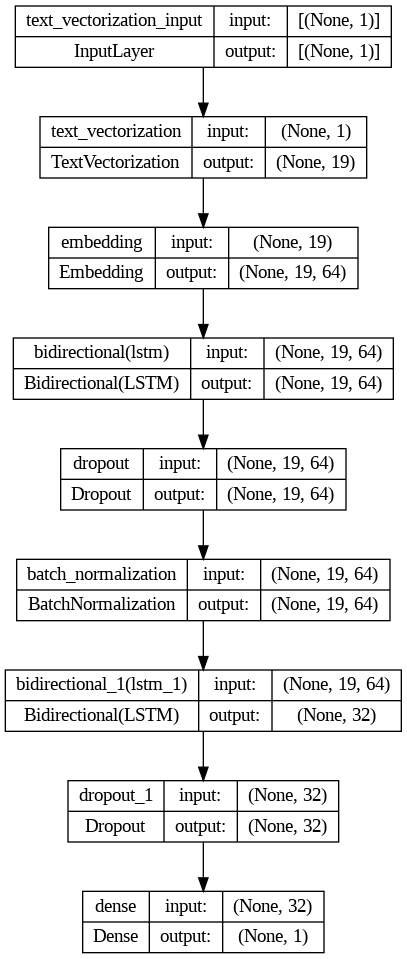

In [30]:
seed = 50
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

input_layer = Input(shape=(max_sen_len,))
model_lstm = Sequential()
model_lstm.add(text_vectorization)
model_lstm.add(embedding)

model_lstm.add(Bidirectional(LSTM(32, return_sequences=True, activation='relu')))
model_lstm.add(Dropout(0.5))
model_lstm.add(tf.keras.layers.BatchNormalization())

model_lstm.add(Bidirectional(LSTM(16, kernel_regularizer=regularizers.l2(0.01),
          activity_regularizer=regularizers.l1(0.01))))
model_lstm.add(Dropout(0.5))

model_lstm.add(Dense(1,activation='sigmoid'))
optimizer = Adam(learning_rate=0.01)

model_lstm.compile(loss='binary_crossentropy',optimizer=optimizer,metrics='accuracy')

tf.keras.utils.plot_model(model_lstm,show_shapes=True)

**Applying** :
- Adding two Bidirectional LSTM layers with 32 and 16 units, respectively. The first LSTM layer returns sequences, and both have dropout and batch normalization to enhance model generalization.
- Adding a dense output layer with a sigmoid activation function, suitable for binary classification tasks.

In [31]:
#model training
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_lstm_1 =model_lstm.fit(X_train,
                         y_train,
                         epochs=50, batch_size=64,
                         validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
13/13 [==============================] - 9s 154ms/step - loss: 1.1096 - accuracy: 0.8712 - val_loss: 0.8244 - val_accuracy: 0.7450
Epoch 2/50
13/13 [==============================] - 1s 43ms/step - loss: 0.3988 - accuracy: 0.9475 - val_loss: 0.7121 - val_accuracy: 0.6750
Epoch 3/50
13/13 [==============================] - 1s 41ms/step - loss: 0.2579 - accuracy: 0.9700 - val_loss: 0.7368 - val_accuracy: 0.6350
Epoch 4/50
13/13 [==============================] - 1s 43ms/step - loss: 0.1736 - accuracy: 0.9875 - val_loss: 0.6194 - val_accuracy: 0.7050
Epoch 5/50
13/13 [==============================] - 1s 66ms/step - loss: 0.1389 - accuracy: 0.9900 - val_loss: 0.6038 - val_accuracy: 0.7400
Epoch 6/50
13/13 [==============================] - 1s 68ms/step - loss: 0.1307 - accuracy: 0.9912 - val_loss: 0.6852 - val_accuracy: 0.7050
Epoch 7/50
13/13 [==============================] - 1s 79ms/step - loss: 0.1166 - accuracy: 0.9900 - val_loss: 0.7485 - val_accuracy: 0.7000
Epoch 8/50
1

Insight : Even with Bidirectional LSTM, the result is still overfitting.

In [32]:
test_loss, test_accuracy = model_lstm.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

7/7 [==============================] - 0s 16ms/step - loss: 0.6038 - accuracy: 0.7400
Test Loss: 0.6037895679473877, Test Accuracy: 0.7400000095367432


<Axes: >

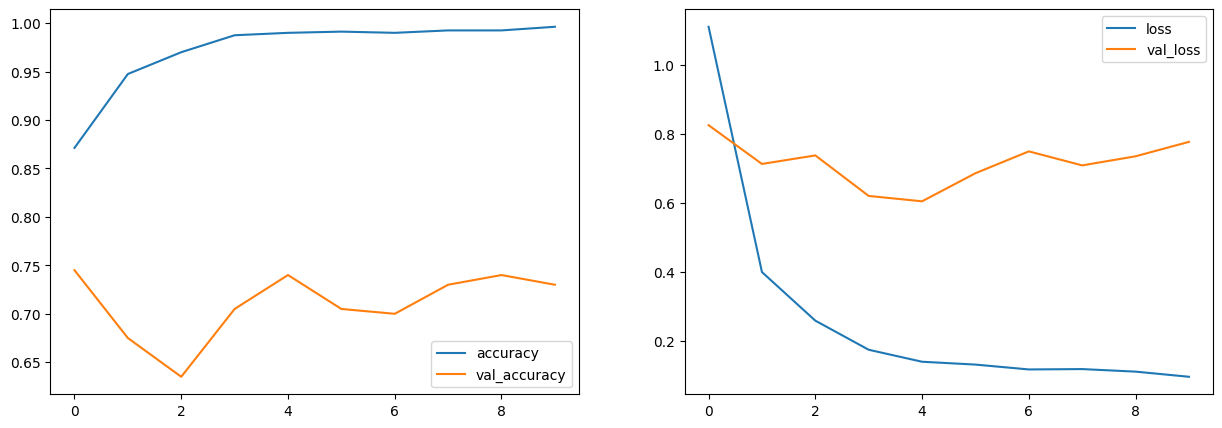

In [33]:
metrics_trf = pd.DataFrame(model_lstm_1.history)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

metrics_trf[['accuracy', 'val_accuracy']].plot(ax=ax1)
metrics_trf[['loss','val_loss']].plot(ax=ax2)

**Evaluation** :
- The model demonstrates strong performance on the training data, achieving a high accuracy of 99.12% and a low training loss of 0.1303.
- The model performs reasonably well on the validation set, with the accuracy ranging from 68% to 74% over the 50 epochs.
- But is a noticeable performance gap between training and validation accuracy, its indicate the overfitting.

**Transfer Learning Model**

 Using a pre-trained embedding layer, this layer is designed for natural language processing tasks and is capable of transforming variable-length texts into fixed-size vectors.

In [34]:
seed = 50
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# importing the embedding layer for transfer learning
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-id-dim128-with-normalization/2", input_shape=[], dtype=tf.string)

model_trf = keras.Sequential()
model_trf.add(hub_layer)
model_trf.add(keras.layers.Dense(16, activation='relu'))
model_trf.add(keras.layers.Dense(1, activation='sigmoid'))

model_trf.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

model_trf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               112461824 
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 112463905 (429.02 MB)
Trainable params: 2081 (8.13 KB)
Non-trainable params: 112461824 (429.01 MB)
_________________________________________________________________


Applying ⁉
- The pre-trained embedding layer (hub_layer) is added as the first layer.
- A Dense layer with 16 units and ReLU activation is added as the second layer.
- A Dense layer with 1 unit and sigmoid activation is added as the output layer for binary classification.

In [35]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_trf_hist = model_trf.fit(X_train,
                         y_train,
                         epochs=100,batch_size=64,
                         validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/100
13/13 [==============================] - 2s 67ms/step - loss: 0.6902 - accuracy: 0.5675 - val_loss: 0.6868 - val_accuracy: 0.5500
Epoch 2/100
13/13 [==============================] - 0s 20ms/step - loss: 0.6800 - accuracy: 0.5950 - val_loss: 0.6808 - val_accuracy: 0.5950
Epoch 3/100
13/13 [==============================] - 0s 22ms/step - loss: 0.6725 - accuracy: 0.6237 - val_loss: 0.6746 - val_accuracy: 0.6300
Epoch 4/100
13/13 [==============================] - 0s 22ms/step - loss: 0.6646 - accuracy: 0.6538 - val_loss: 0.6687 - val_accuracy: 0.6250
Epoch 5/100
13/13 [==============================] - 0s 21ms/step - loss: 0.6566 - accuracy: 0.6750 - val_loss: 0.6626 - val_accuracy: 0.6550
Epoch 6/100
13/13 [==============================] - 0s 20ms/step - loss: 0.6488 - accuracy: 0.6825 - val_loss: 0.6558 - val_accuracy: 0.6500
Epoch 7/100
13/13 [==============================] - 0s 20ms/step - loss: 0.6403 - accuracy: 0.6925 - val_loss: 0.6492 - val_accuracy: 0.6500
Epoch 

In [36]:
test_loss, test_accuracy = model_trf.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

7/7 [==============================] - 0s 3ms/step - loss: 0.5020 - accuracy: 0.7700
Test Loss: 0.5020483732223511, Test Accuracy: 0.7699999809265137


<Axes: >

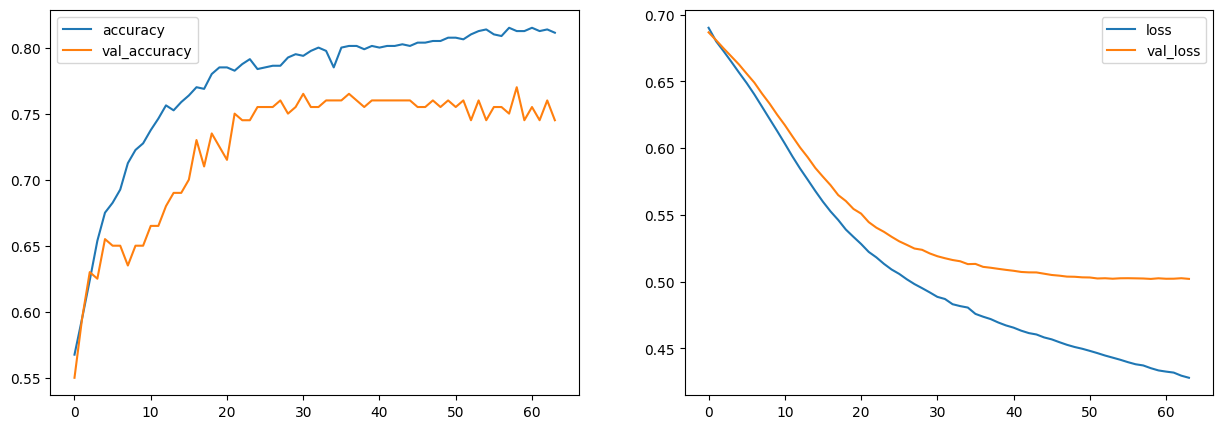

In [37]:
metrics_trf = pd.DataFrame(model_trf_hist.history)
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

metrics_trf[['accuracy', 'val_accuracy']].plot(ax=ax1)
metrics_trf[['loss','val_loss']].plot(ax=ax2)

Evaluation :
- As we expected from the transfer learning model, The accuracy and loss both in train and validation data reached an excellent performance.
- The model appears to have a reasonably good fit
- We will use the transfer learning model to make a prediction

# Model Saving

In [38]:
# freeze model LSTM
model_trf.trainable = False
model_trf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               112461824 
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 112463905 (429.02 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 112463905 (429.02 MB)
_________________________________________________________________


In [39]:
#saving model LSTM
model_trf.save('FINAL_TRF.tf')
model_trf.save('FINAL_TRF.h5')

# Conclusion

A. EDA
  - Liked feature have a balance data between Like and Not Like.
  - For stopword before and after preprocessing didnt have a sigmificant differences.

B. Model
- For model using ANN base, Bidirectional GRU and Bidirection LSTM we got great accuracy of 99% for training data, but just around 73% for test data. Is clearly the models are overfitting. From my analysis, I think its happen because the limited dataset.
- GRU and Bidirectional LSTM  might struggle to capture the intricate relationships present in the data without sufficient training examples.
- Transfer learning often involves using pre-trained models on large datasets, which have learned general features and representations. This can be beneficial when we have limited data.

C. Further Improvement
- Try different model architectures for future sentiment analysis task
- Consider data augmentation techniques to artificially increase the size of  training dataset.
- Try another varience of Hyperparameter Tuning(learning rate, dropout rates, etc.)
